Imports 
===========================================================================================================================

In [1]:
# %matplotlib notebook

# Reload module
import importlib
import utils.general
importlib.reload(utils.general)

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Project imports
from utils.loader.single_task_loader import SingleTaskExperimentLoader
from utils.general import get_latest_run_dir, extract_seed_from_dir, extract_timestamp_from_dir, get_all_experiment_runs, get_seed_time_pairs_for_models


Parameters
===========================================================================================================================

In [2]:
# Stochastic Models
stoch_models = {"IC_FDNet", "LP_FDNet", "BayesNet", "GaussHyperNet", "DeepEnsembleNet"}
# Deterministic Models
det_models = {"HyperNet", "MLPNet"}
# Stochastic Metrics
stoch_metrics = {"var", "nll", "std"}
# Get latest run directory
get_latest_run = True
# Models and metadata
# model_types = ['IC_FDNet', 'BayesNet', 'GaussHyperNet', 'MLPNet', 'DeepEnsembleNet']
model_types = ['LP_FDNet', 'HyperNet', 'IC_FDNet', 'BayesNet', 'GaussHyperNet', 'MLPNet', 'DeepEnsembleNet']
# Seeds
seeds = [8138]
# Date-time string
date_times = ["2025-07-30_22-20-47"]
# Check and make sure the seed/ date-time pair is in the list
runs_list = get_all_experiment_runs(base_dir="results//single_task_experiment")
seed_data_time_list = get_seed_time_pairs_for_models(runs=runs_list, model_type_list=model_types)
if seeds is None or date_times is None:
    seed_data_time_list = [(seed, date_time) for seed, date_time in seed_data_time_list]

else:
    seed_data_time_list = [(seed, date_time) for seed, date_time in seed_data_time_list if seed in seeds and date_time in date_times]

# Define consistent colors for each model type
model_colors = {
    'IC_FDNet': '#1f77b4',         # Blue
    'LP_FDNet': '#ff7f0e',         # Orange
    'BayesNet': '#2ca02c',         # Green
    'GaussHyperNet': '#d62728',    # Red
    'DeepEnsembleNet': '#9467bd',  # Purple
    'HyperNet': '#8c564b',         # Brown
    'MLPNet': '#e377c2',           # Pink
}


Load Data
=

In [3]:
# Pre-allocate dictionaries
loaders = {}
x_train, y_train, x_test, y_test = {}, {}, {}, {}

# Metrics: metrics[metric_name][(seed, date_time)][model]
metrics = {
    "mean": {}, "var": {}, "std": {}, "res_precision": {}, "res_accuracy": {},
    "bias": {}, "mse": {}, "bias_var_diff": {}, "nll": {}
}

# Losses: losses[loss_type][(seed, date_time)][model]
losses = {
    "losses": {}, "mses": {}, "kls": {}, "betas": {}
}

# Summary: summary[summary_name][(seed, date_time)][model]
summary = {
'desc': {}, 'model': {}, 'seed': {}, 'rmse': {}, 'mean_nll': {}, 'training_time': {}, 'timestamp': {},
'epochs': {}, 'beta_param_dict': {}, 'x_min': {}, 'x_max': {}, 'region_interp': {}, 'frac_train': {}
}

for seed, date_time in seed_data_time_list:
    for model in model_types:
        run_tag = f"{model}_seed{seed}_{date_time}"
        try:
            # Initialize loader
            loader = SingleTaskExperimentLoader(model, seed, date_time)

            # Load and store metrics
            metric_dict = loader.load_metrics()
            for k in metrics:
                metrics[k].setdefault((seed, date_time), {})[model] = metric_dict[k]

            # Load and store losses
            loss_dict = loader.load_loss_curve()
            for k in losses:
                losses[k].setdefault((seed, date_time), {})[model] = loss_dict[k]

            # Load summary
            summary_dict = loader.load_summary()
            for k in summary:
                summary[k].setdefault((seed, date_time), {})[model] = summary_dict[k]

            # Store loader
            loaders.setdefault((seed, date_time), {})[model] = loader

        except FileNotFoundError:
            print(f"⚠️  Skipping missing result: {run_tag}")
        finally:
            print(f"Checked: {run_tag}")

    # Load data (only once per (seed, date_time))
    try:
        data = loader.load_data()
        x_train[(seed, date_time)] = data["x_train"]
        y_train[(seed, date_time)] = data["y_train"]
        x_test[(seed, date_time)] = data["x_test"]
        y_test[(seed, date_time)] = data["y_test"]
    except Exception as e:
        print(f"⚠️  Failed to load data for {seed}_{date_time}: {e}")

print("✅ Loaded runs:", list(loaders.keys()))

Checked: LP_FDNet_seed8138_2025-07-30_22-20-47
Checked: HyperNet_seed8138_2025-07-30_22-20-47
Checked: IC_FDNet_seed8138_2025-07-30_22-20-47
Checked: BayesNet_seed8138_2025-07-30_22-20-47
Checked: GaussHyperNet_seed8138_2025-07-30_22-20-47
Checked: MLPNet_seed8138_2025-07-30_22-20-47
Checked: DeepEnsembleNet_seed8138_2025-07-30_22-20-47
✅ Loaded runs: [(8138, '2025-07-30_22-20-47')]


Metric Overlay Plots
=

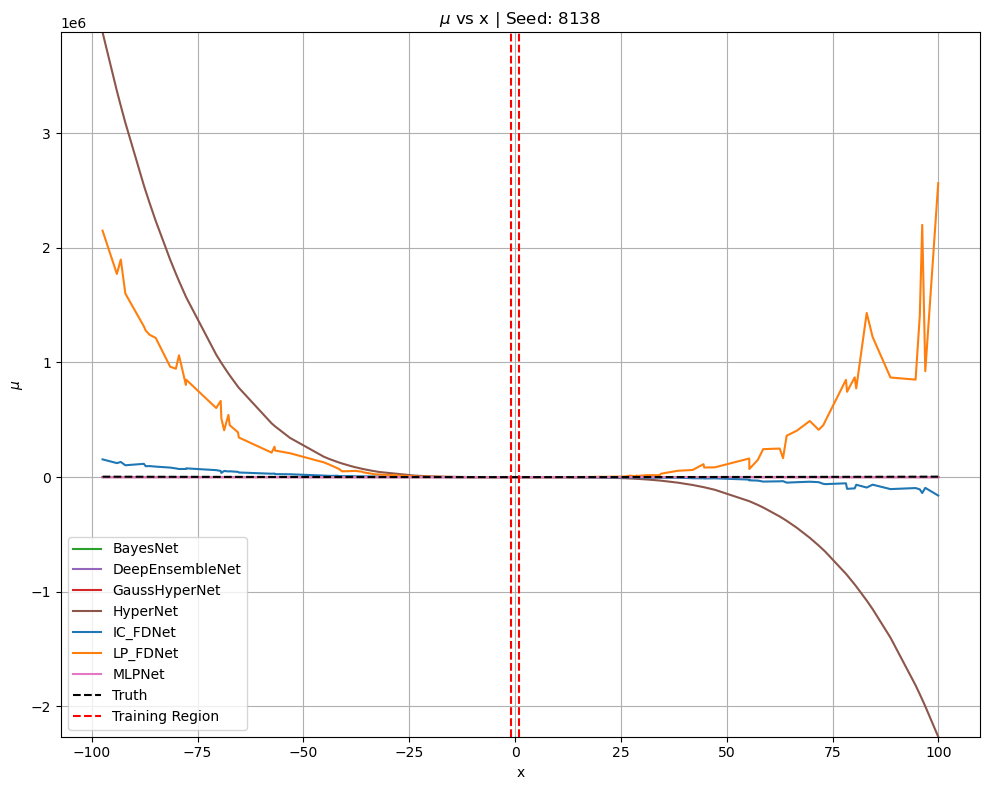

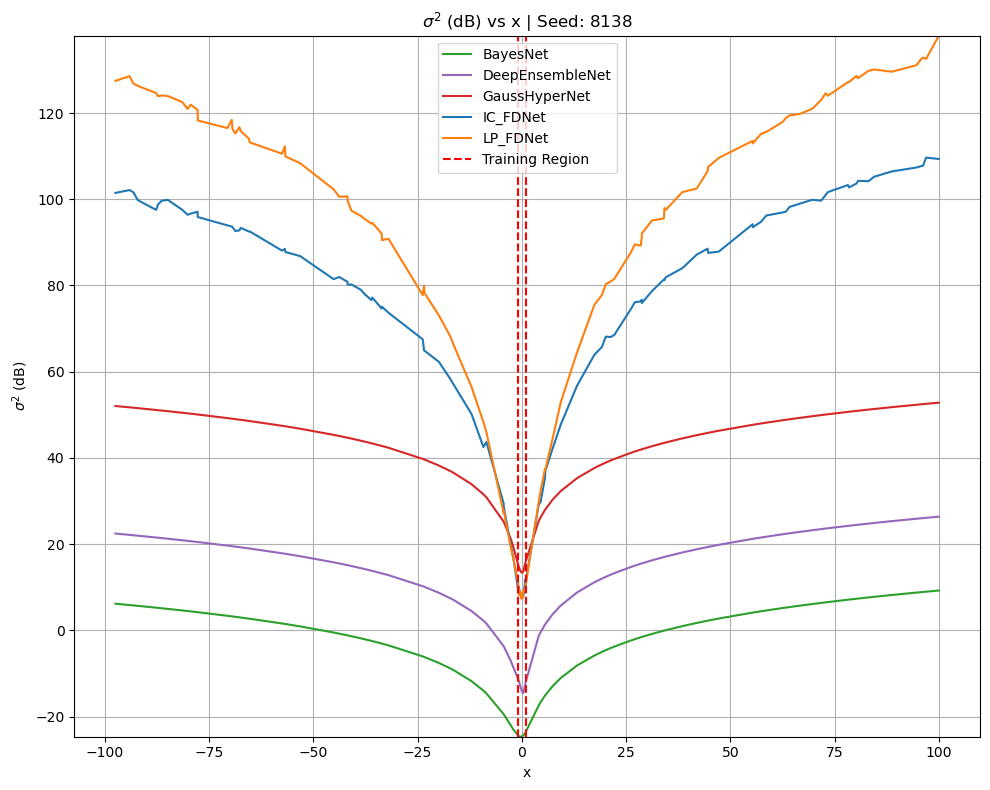

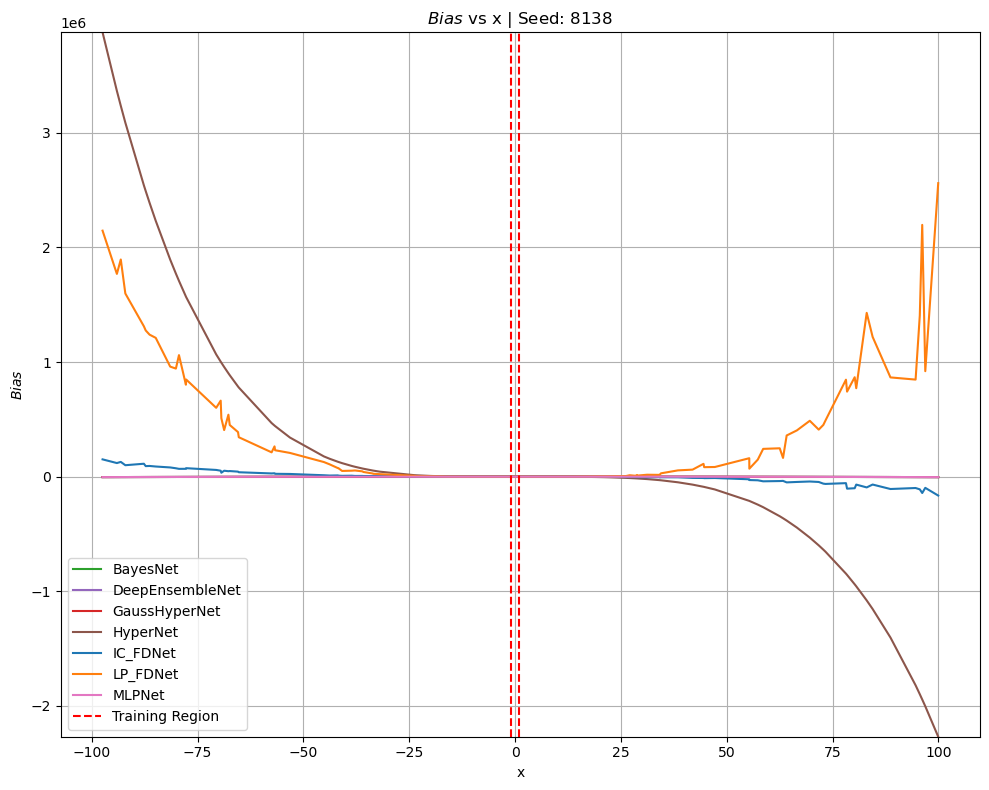

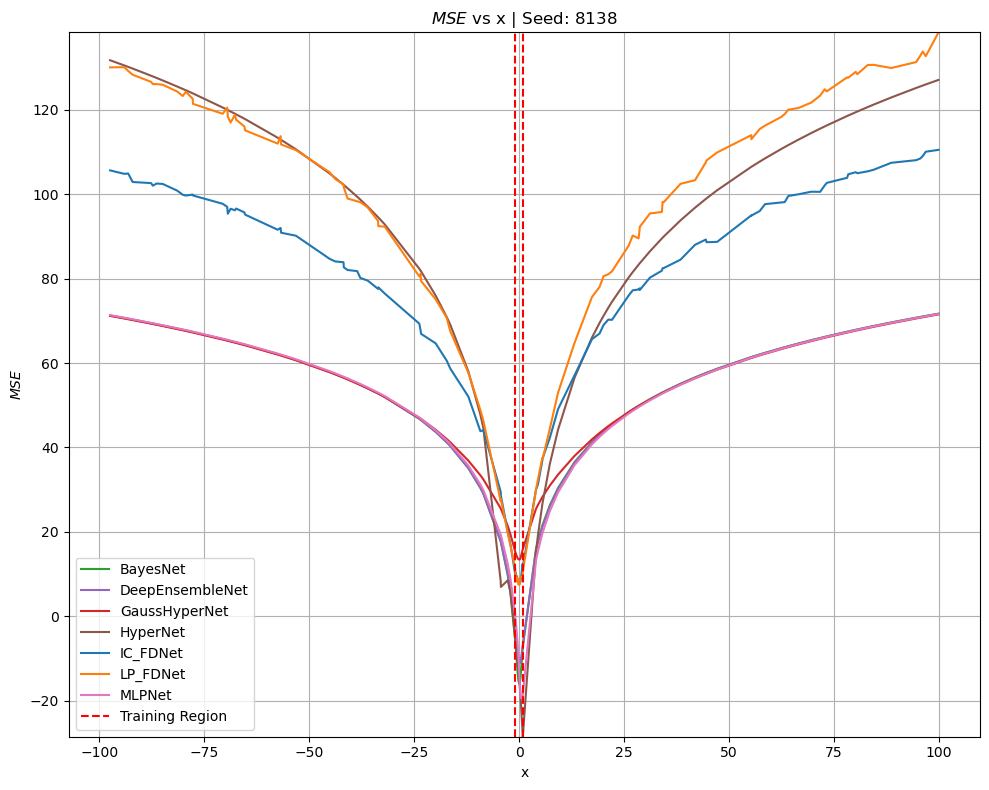

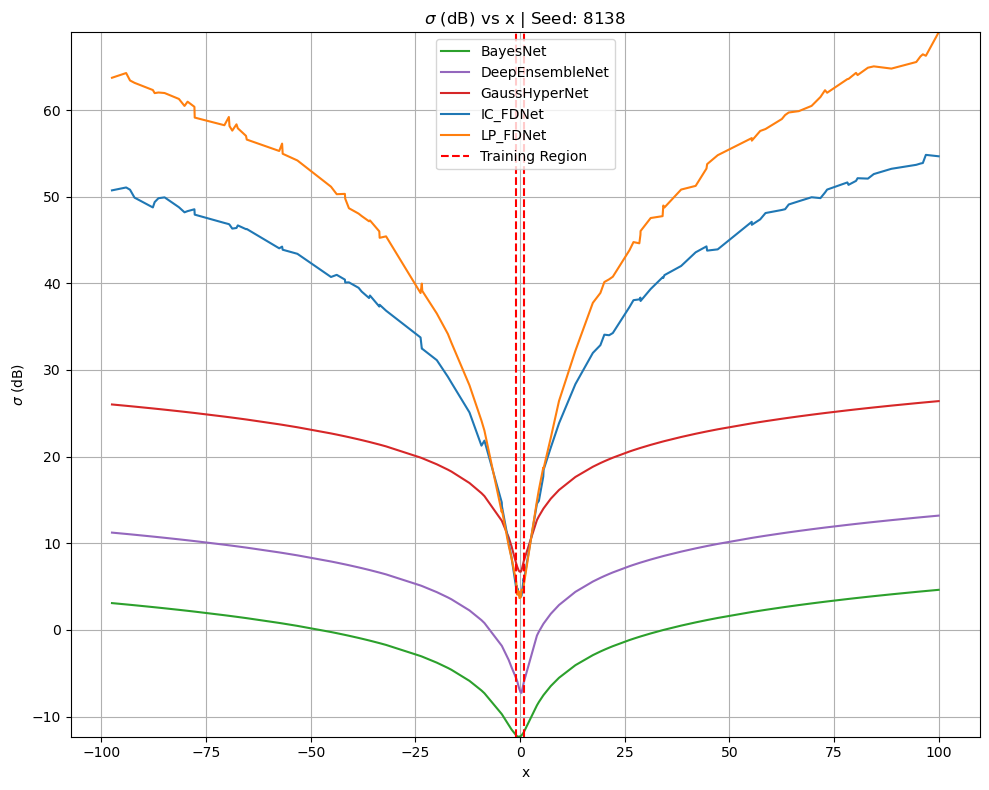

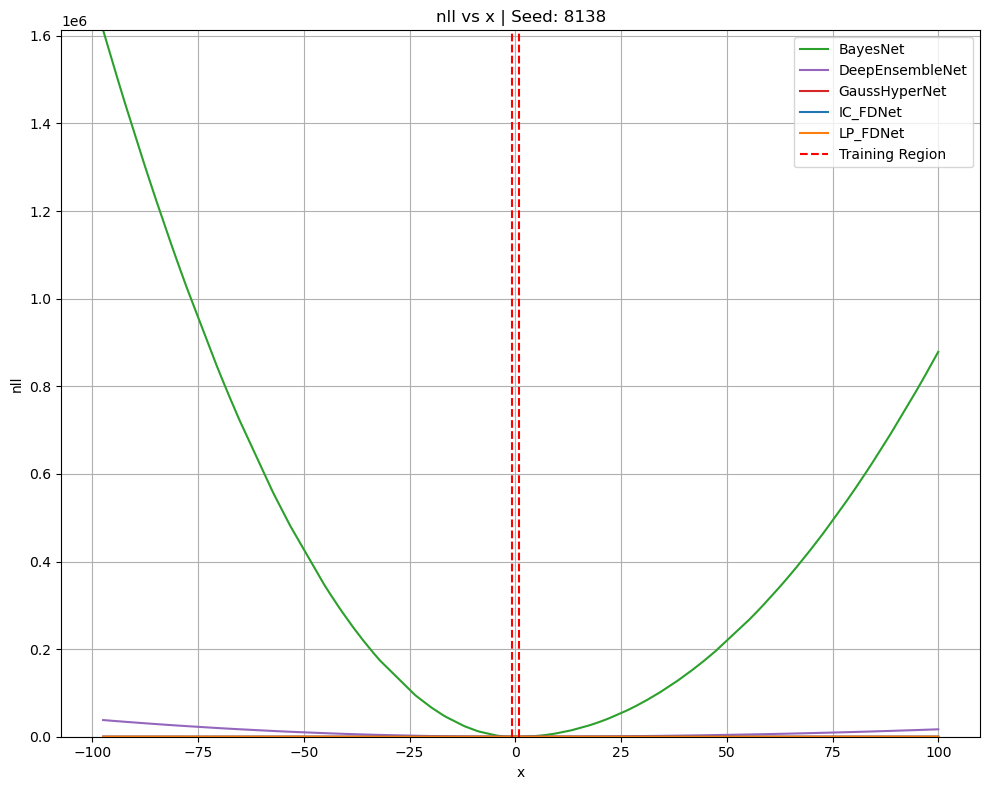

In [4]:
for seed_date_time in seed_data_time_list:
    x = x_test[seed_date_time]
    y = y_test[seed_date_time]

    x_min = np.min(x_train[seed_date_time])
    x_max = np.max(x_train[seed_date_time])

    for metric_label in {"mean", "var", "std", "bias", "mse", "nll"}:
        stoch = metric_label in stoch_metrics
        models = sorted(stoch_models.intersection(model_types)) if stoch else sorted(model_types)

        fig, ax = plt.subplots(figsize=(10, 8))
        metric_min, metric_max = None, None

        for model in models:
            # if model not in metrics[metric_label][seed_date_time]:
            #     print(f"Skipping {model} for {metric_label} (data not found)")
            #     continue

            metric = metrics[metric_label][seed_date_time][model]

            # Convert to dB where appropriate
            if metric_label in {"var", "std", "mse"}:
                metric = 10 * np.log10(np.maximum(metric, 1e-10))
                # plot_label = f"{metric_label} (dB)"
                plot_label = "$\sigma^{2}$ (dB)" if metric_label == "var" else "$\sigma$ (dB)" if metric_label == "std" else "$MSE$"
            else:
                plot_label = "$\mu$" if metric_label == "mean" else "$Bias$" if metric_label == "bias" else metric_label

            ax.plot(x, metric, label=model, color=model_colors.get(model, None))  # use consistent color
            metric_min = np.min(metric) if metric_min is None else min(metric_min, np.min(metric))
            metric_max = np.max(metric) if metric_max is None else max(metric_max, np.max(metric))

        if metric_label == "mean":
            metric_min = min(metric_min, np.min(y))
            metric_max = max(metric_max, np.max(y))
            ax.plot(x, y, label="Truth", linestyle='--', color='black')

        ax.axvline(x=x_min, color='red', linestyle='--', label='Training Region')
        ax.axvline(x=x_max, color='red', linestyle='--')

        ax.set_ylim([metric_min, metric_max])
        ax.set_title(f"{plot_label} vs x | Seed: {seed_date_time[0]}")
        ax.set_xlabel("x")
        ax.set_ylabel(plot_label)
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

Loss Overlay Plots
=

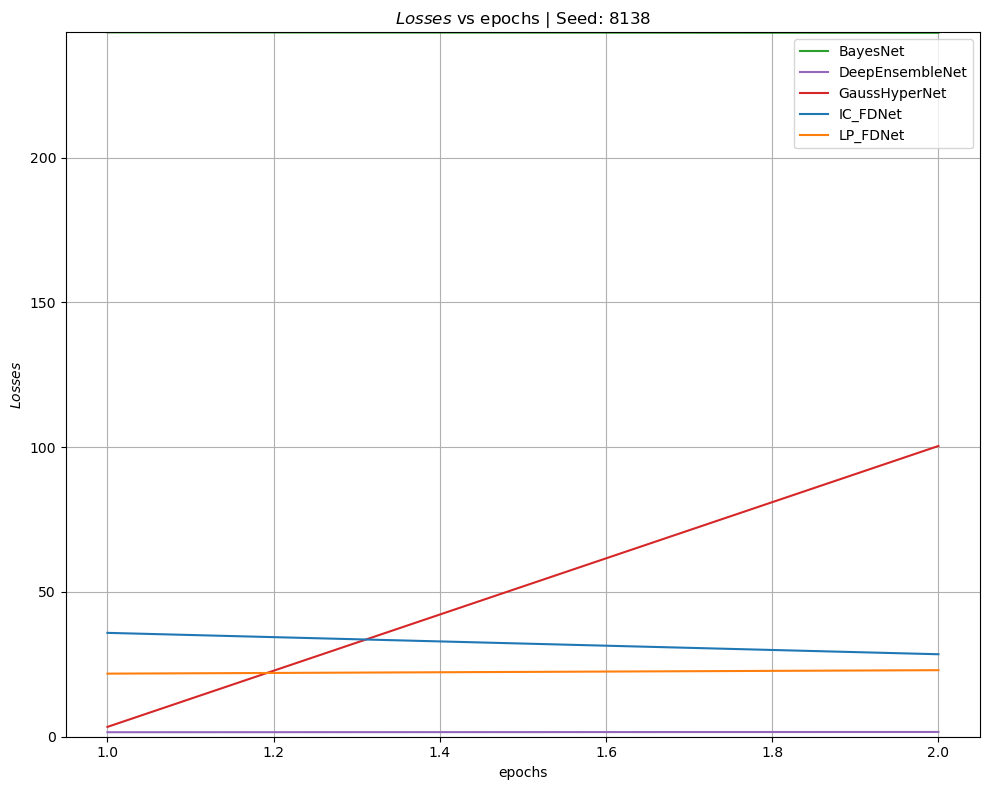

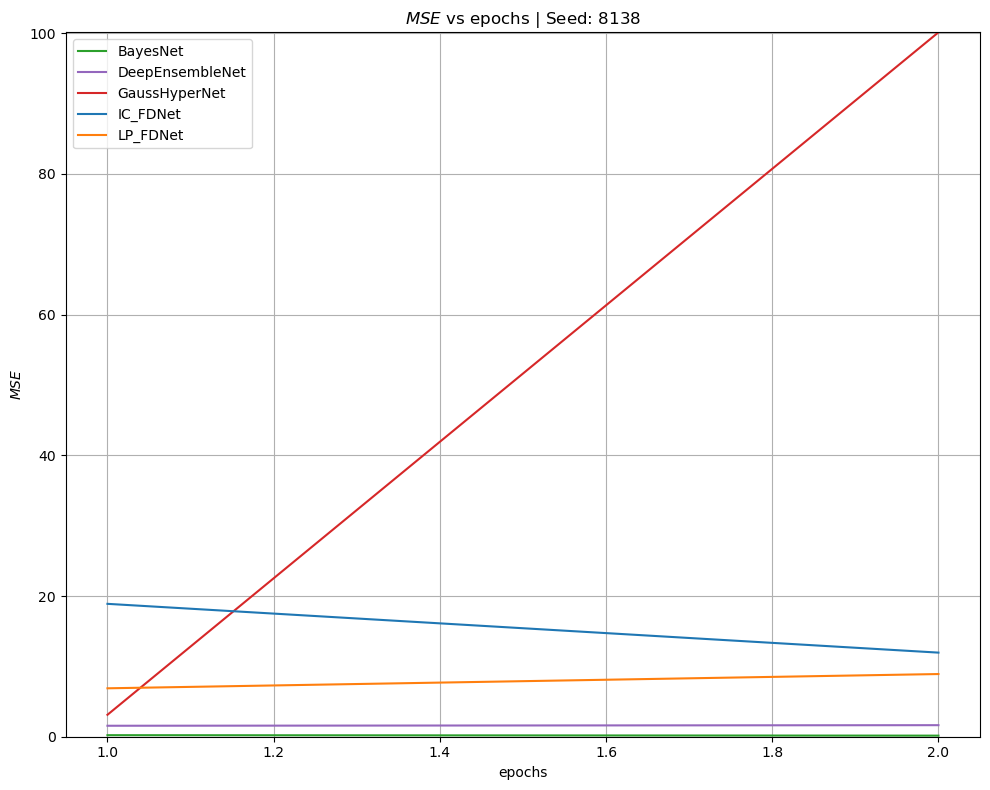

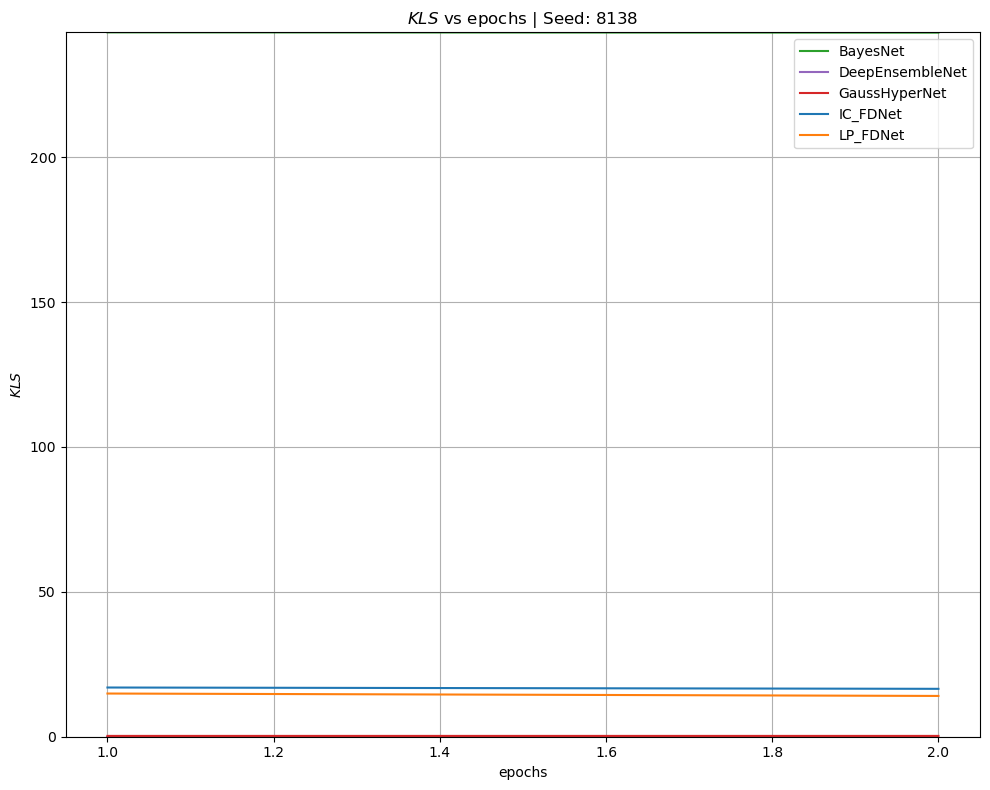

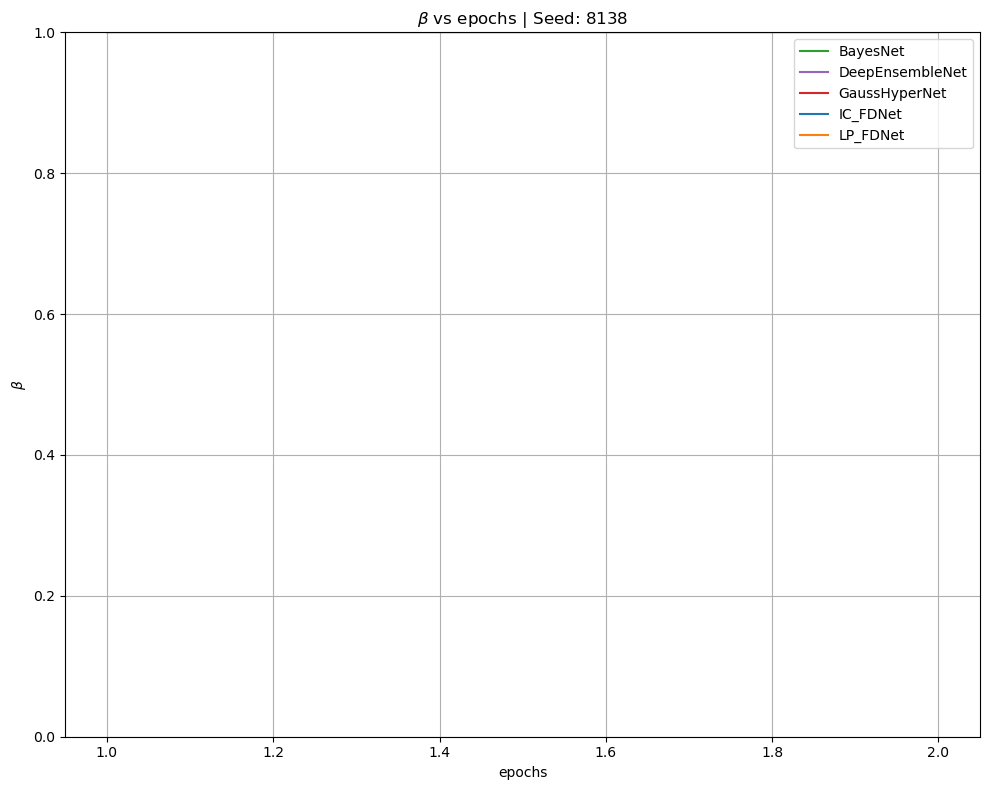

In [5]:
for seed_date_time in seed_data_time_list:

    for label in losses.keys():

        fig, ax = plt.subplots(figsize=(10, 8))
        value_max = None

        for model in models:
            if model not in stoch_models and label in {"kls", "losses", "betas"} :
                continue

            value = losses[label][seed_date_time][model]

            ax.plot([n+1 for n in range(len(value))], value, label=model, color=model_colors.get(model, None))  # use consistent color
            value_max = np.max(value) if value_max is None else max(value_max, np.max(value))

        label_map = {
        "mses": "$MSE$",
        "losses": "$Losses$",
        "kls": "$KLS$",
        "betas": r"$\beta$"
        }
        label = label_map.get(label, label)  # fallback to original if not found
        ax.set_ylim([0, value_max])
        ax.set_title(f"{label} vs epochs | Seed: {seed_date_time[0]}")
        ax.set_xlabel("epochs")
        ax.set_ylabel(label)
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

$Bias^{2}$ vs $\sigma_{\hat{y}}^{2}$
=

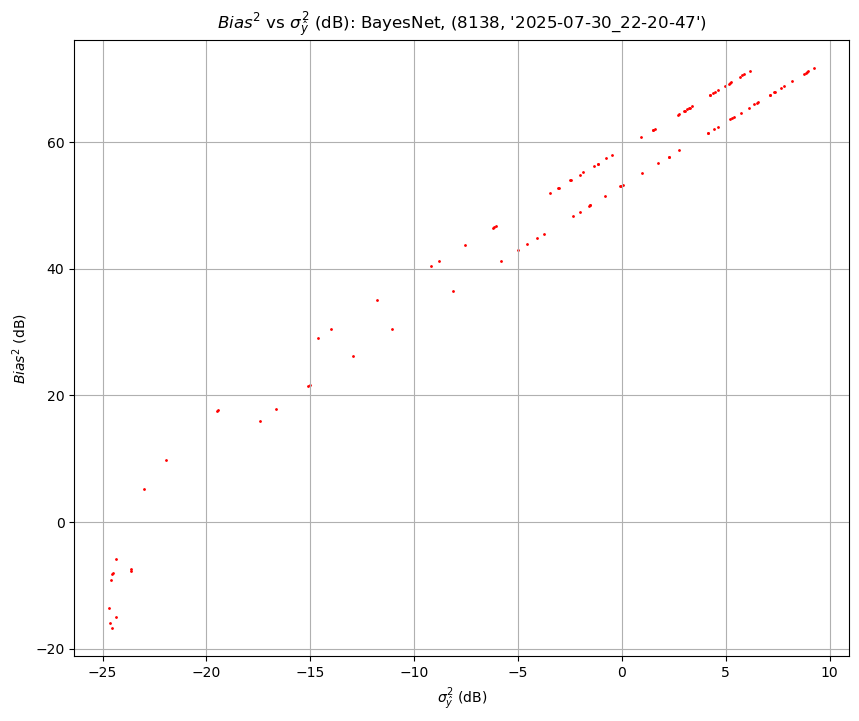

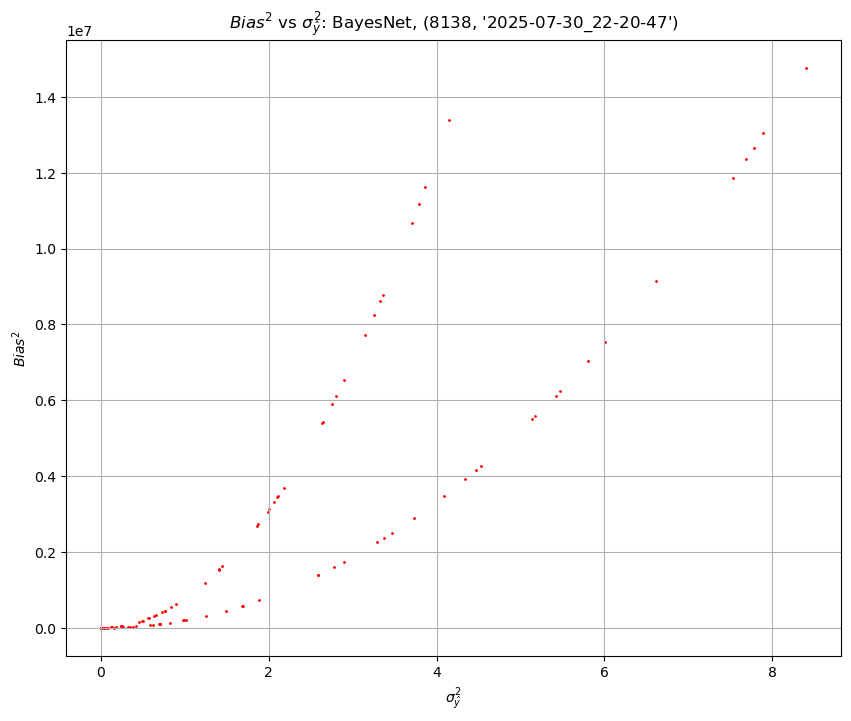

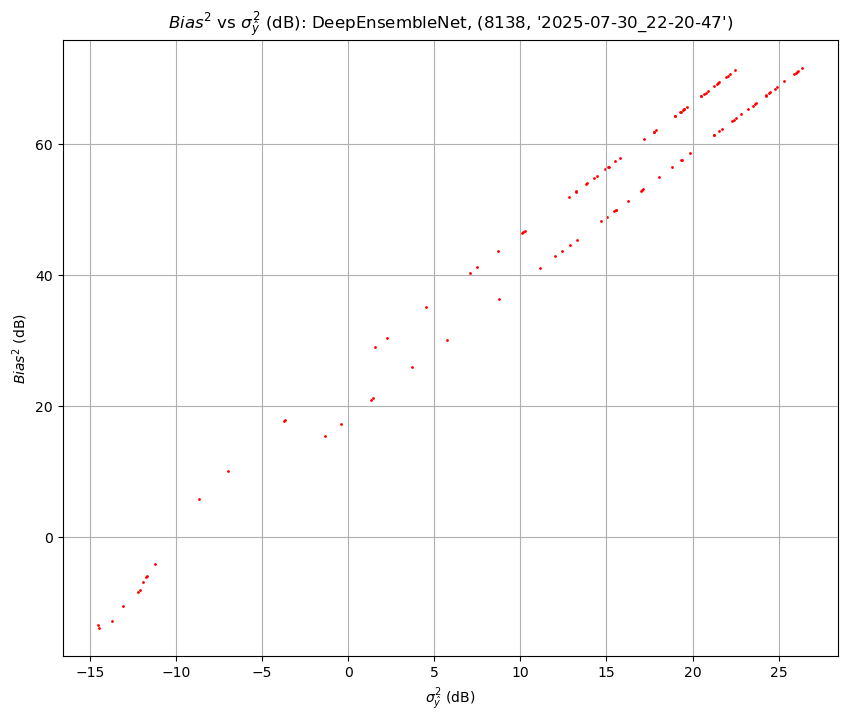

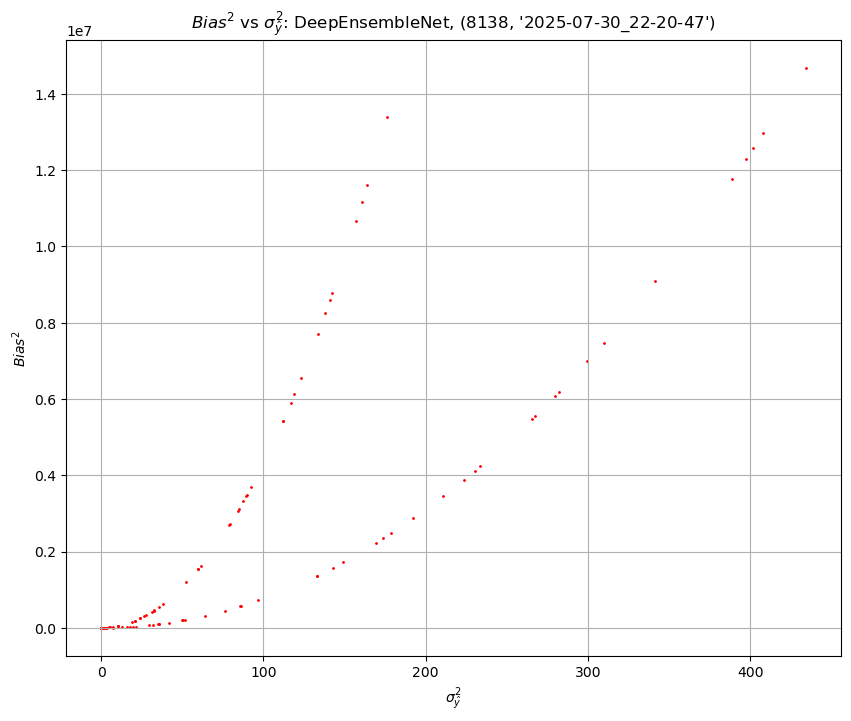

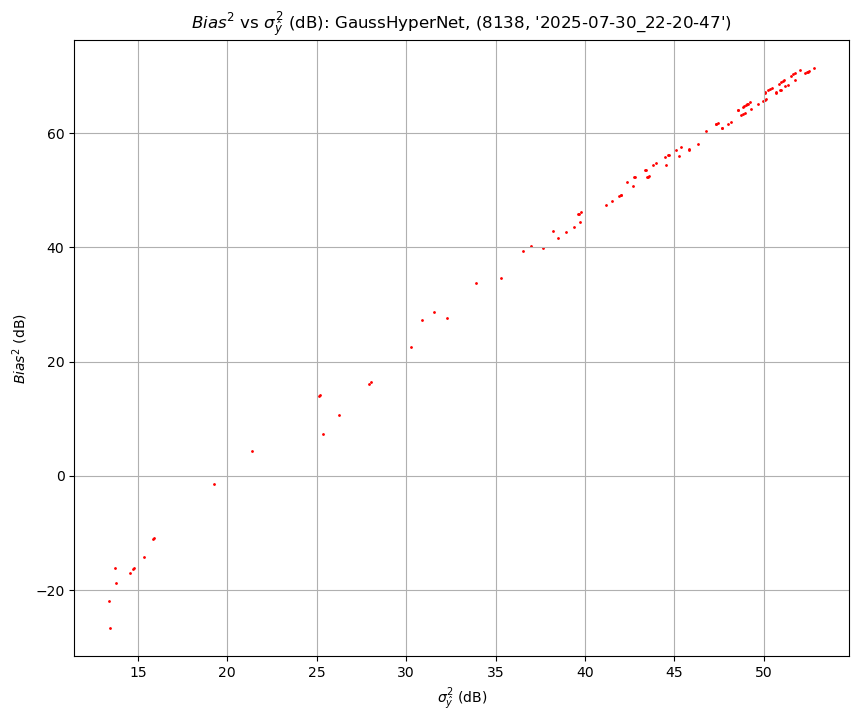

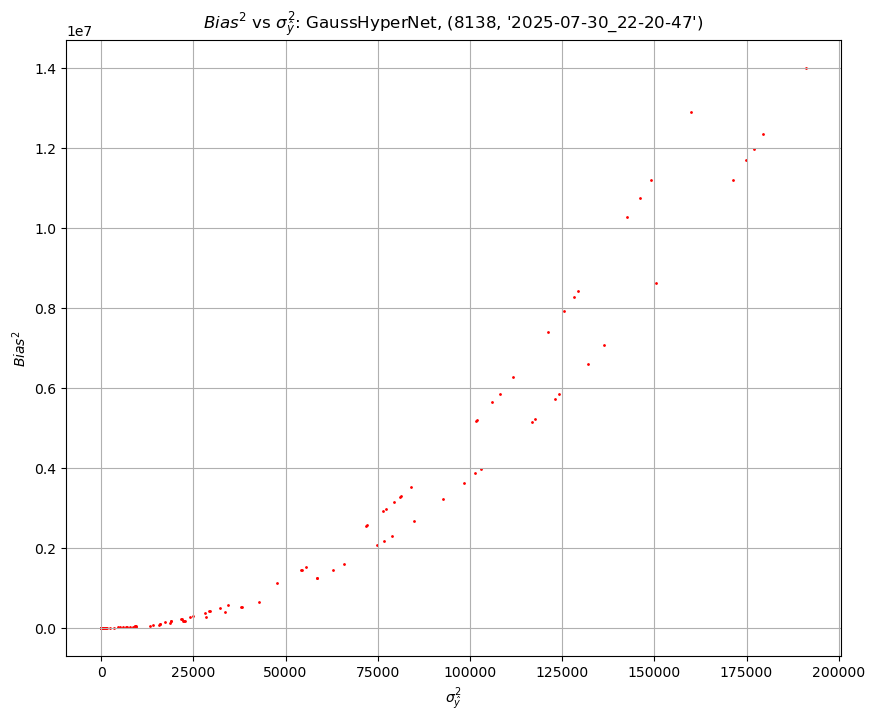

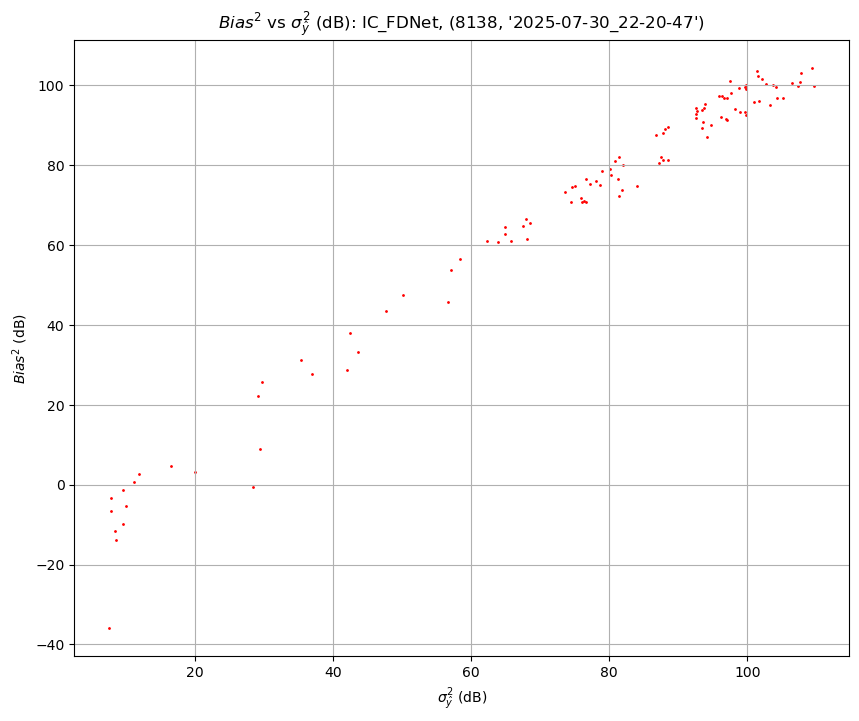

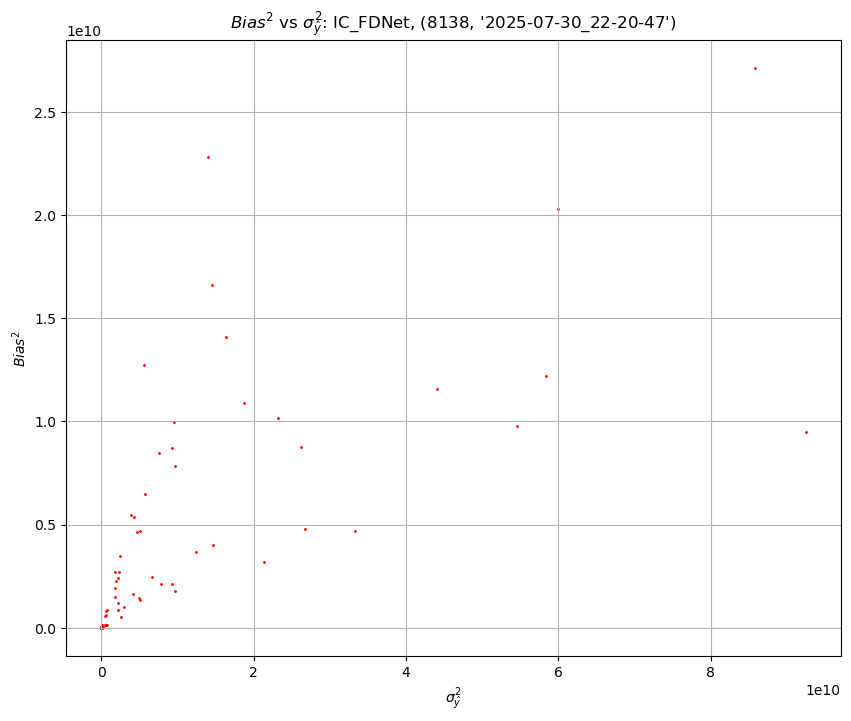

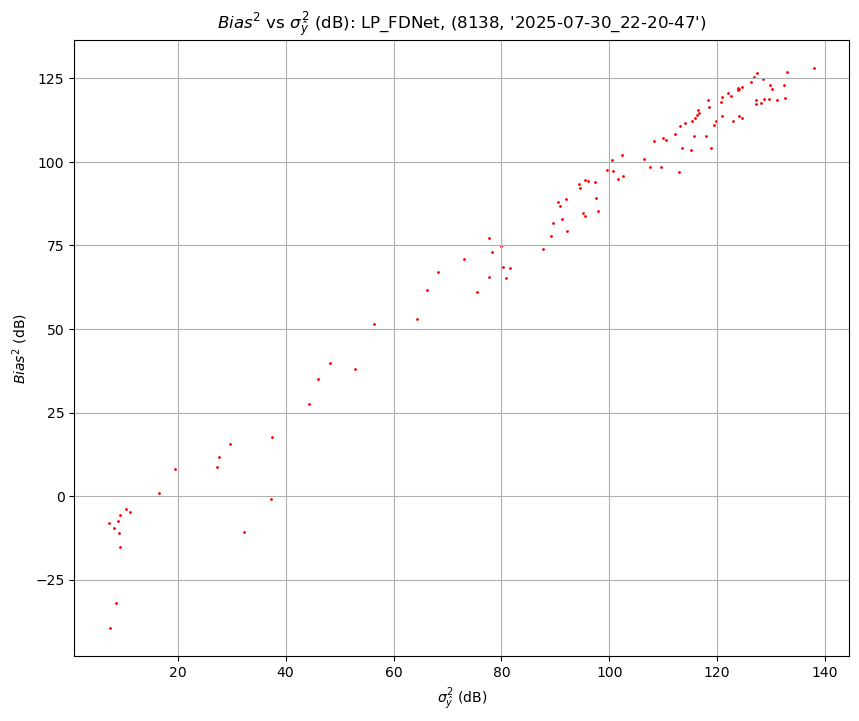

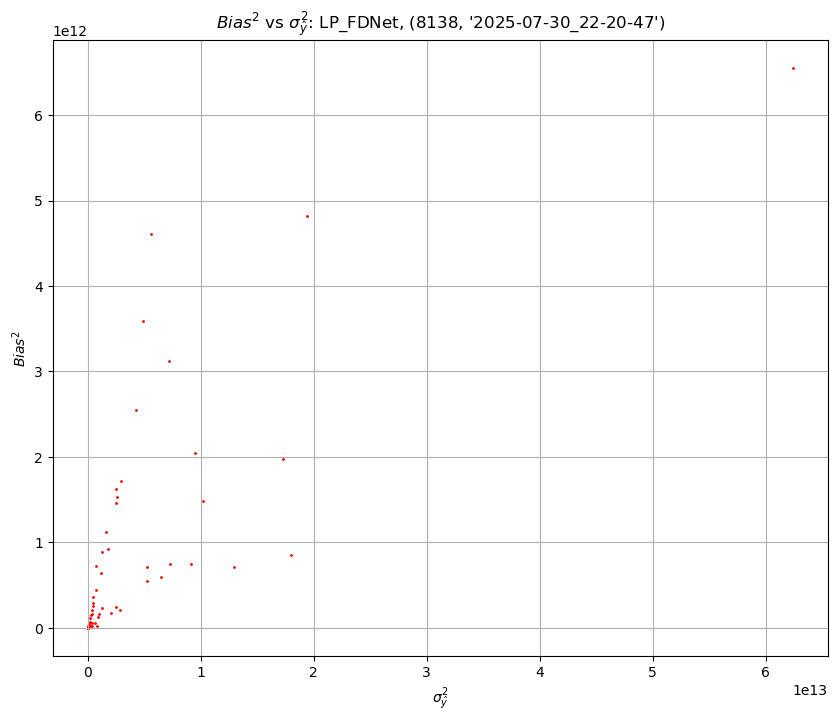

In [6]:
for seed_date_time in seed_data_time_list:

    stoch = metric_label in stoch_metrics
    models = sorted(stoch_models.intersection(model_types))

    for model in models:

        x = x_test[seed_date_time]
        y = y_test[seed_date_time]

        # mean = metrics["mean"][seed_date_time][model]
        var = metrics["var"][seed_date_time][model]

        bias = metrics["bias"][seed_date_time][model]
        # mse = metrics["mse"][seed_date_time][model]

        # res_prec = metrics["res_precision"][seed_date_time][model]
        # res_acc = metrics["res_accuracy"][seed_date_time][model]
    
        plt.figure(figsize=(10,8))
        plt.scatter(10*np.log10(var), 10*np.log10(bias**2), alpha=1.0, s=1, c="red")
        plt.xlabel("$\sigma_{\hat{y}}^{2}$ (dB)")
        plt.ylabel("$Bias^{2}$ (dB)")
        plt.title("$Bias^{2}$ vs $\sigma_{\hat{y}}^{2}$ (dB): " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10,8))
        plt.scatter(var, bias**2, alpha=1.0, s=1, c="red")
        plt.xlabel("$\sigma_{\hat{y}}^{2}$")
        plt.ylabel("$Bias^{2}$")
        plt.title("$Bias^{2}$ vs $\sigma_{\hat{y}}^{2}$: " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()




$MSE$ vs $\sigma_{\hat{y}}^{2}$
=

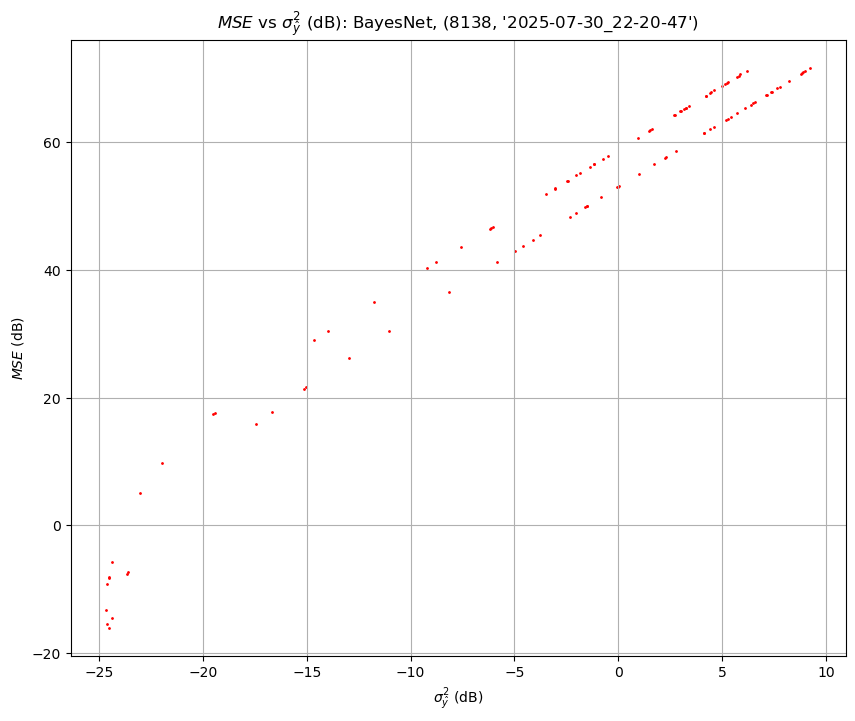

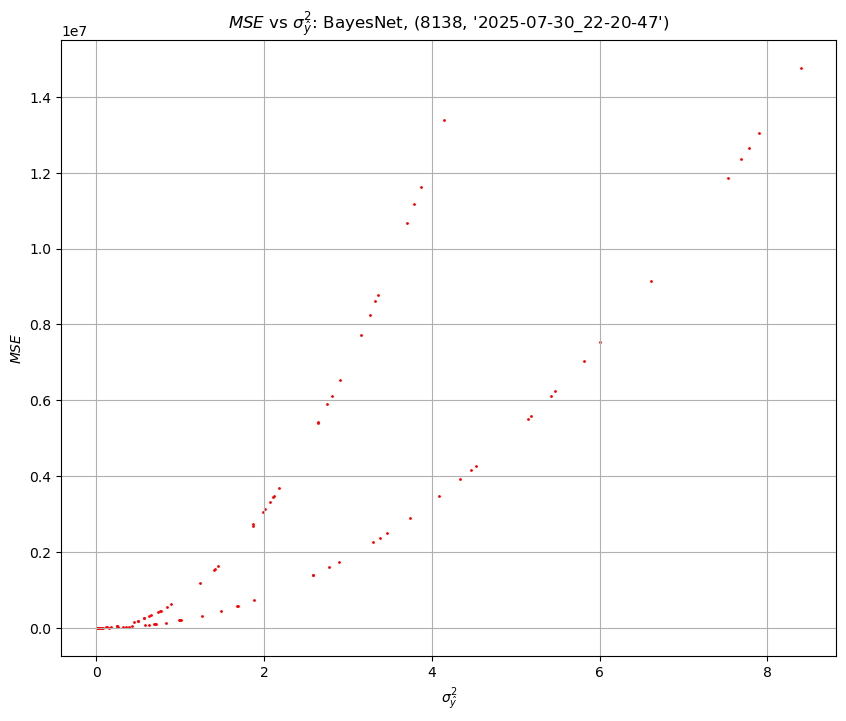

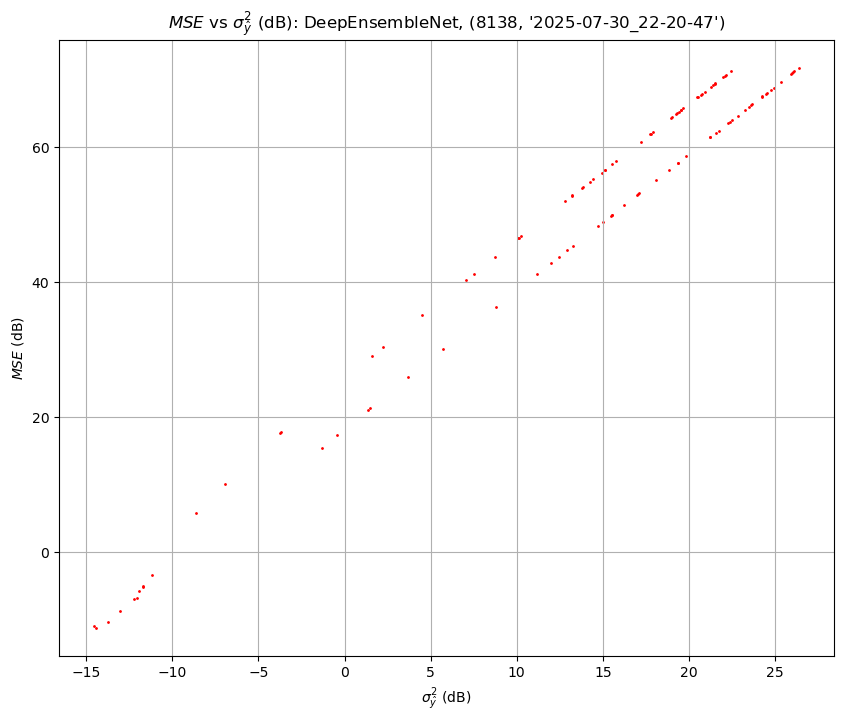

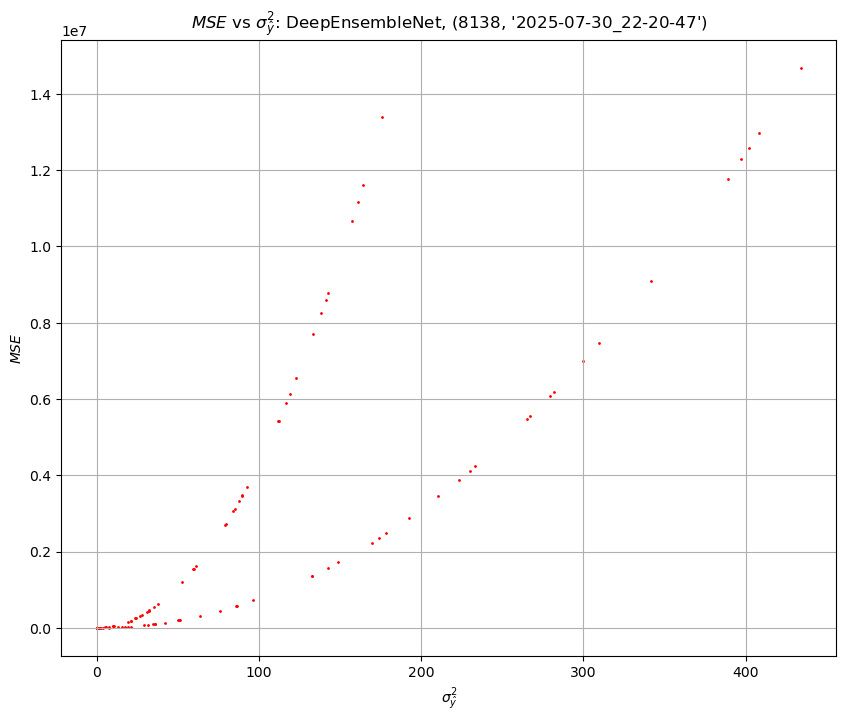

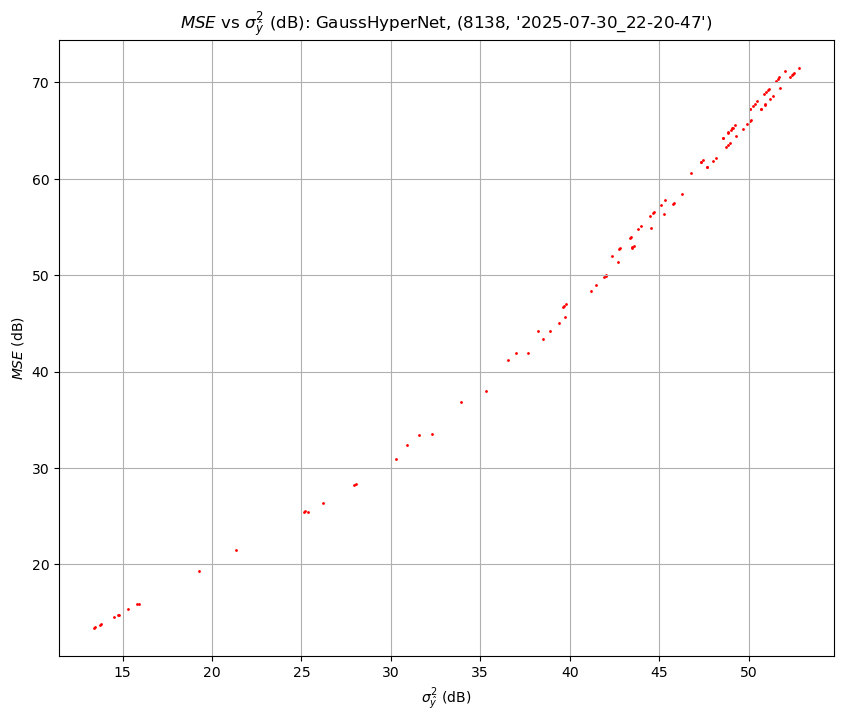

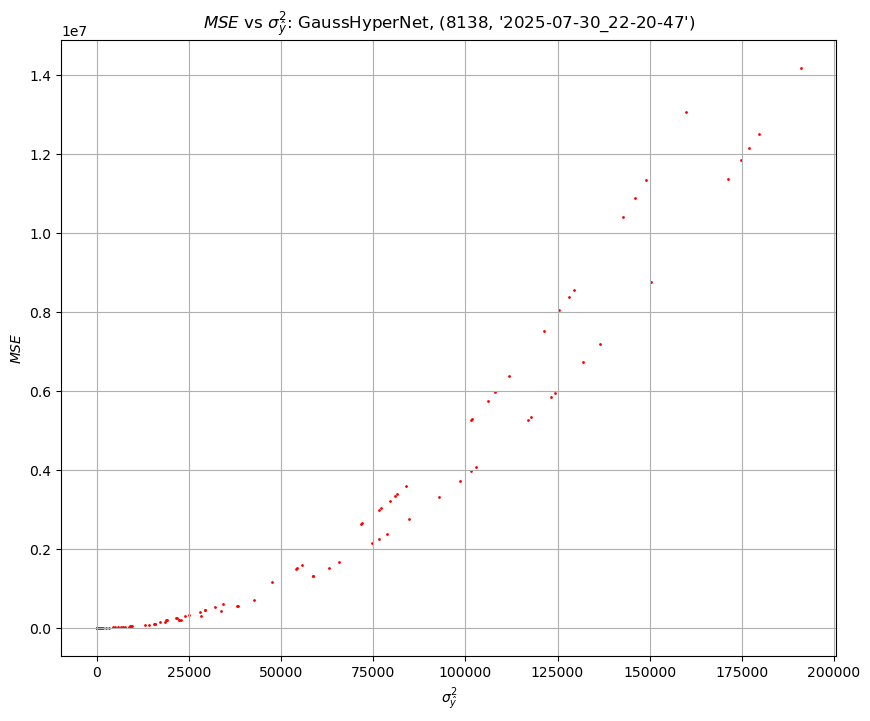

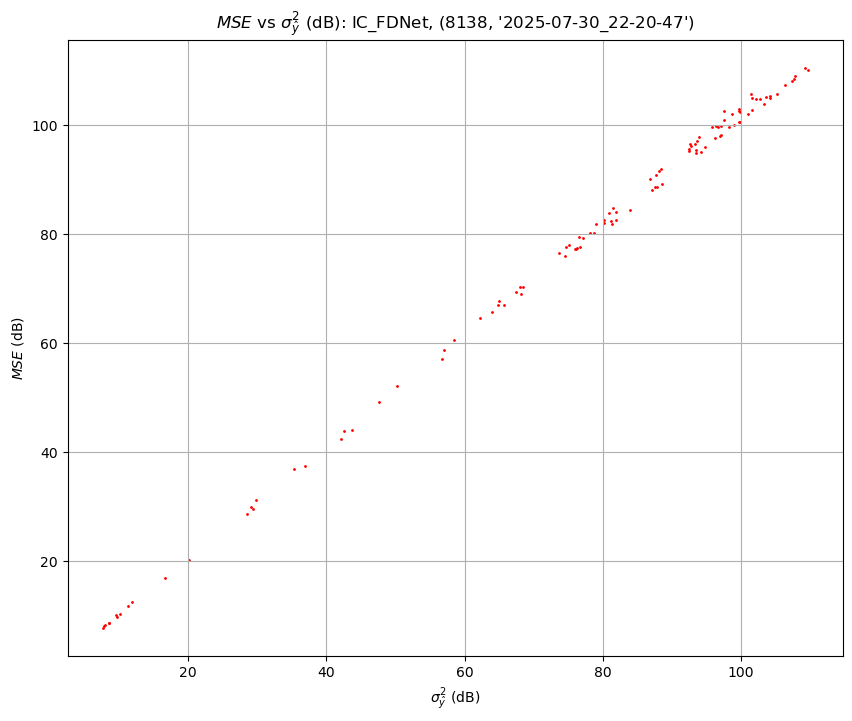

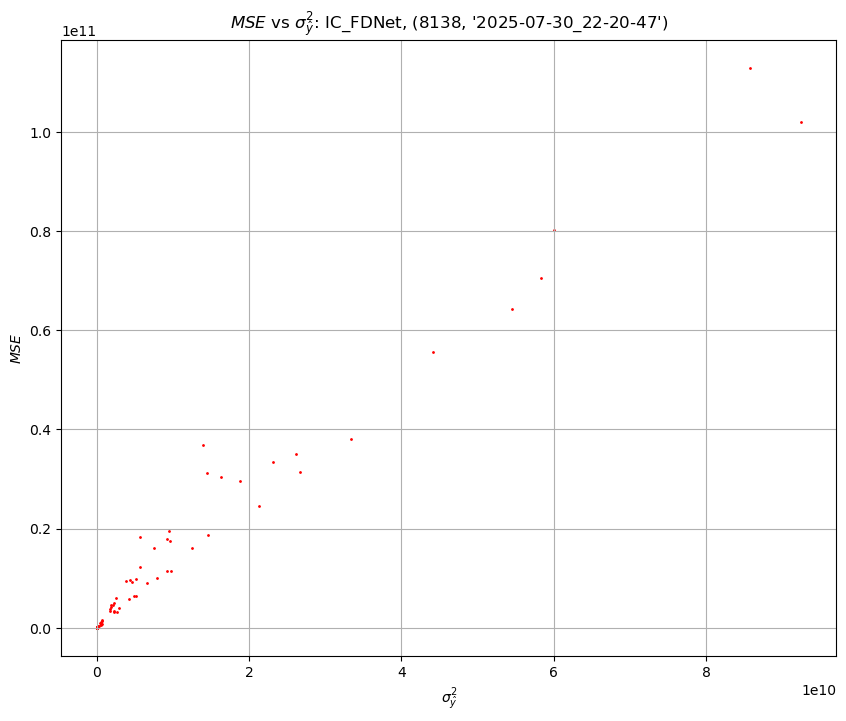

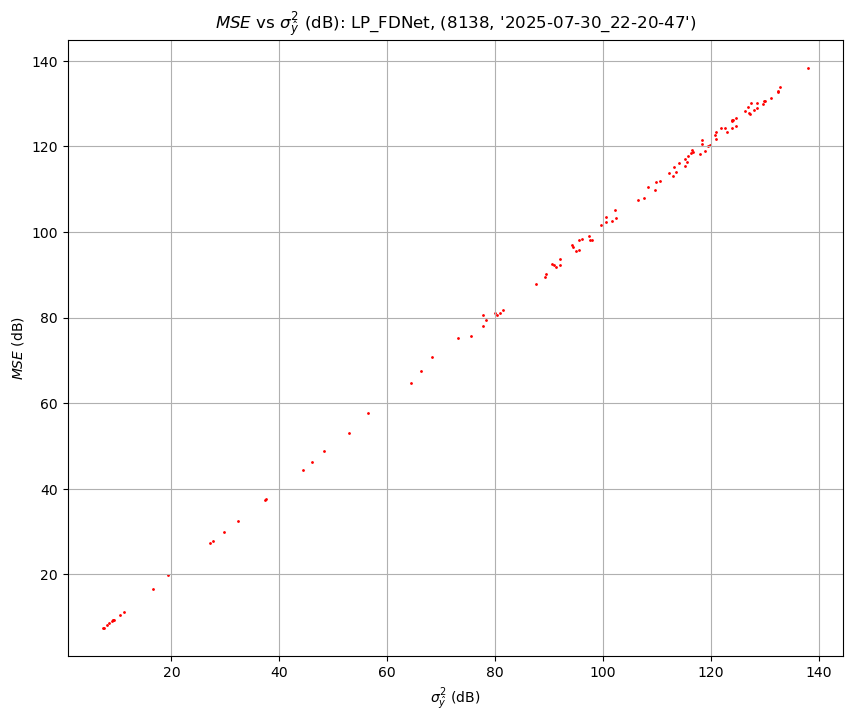

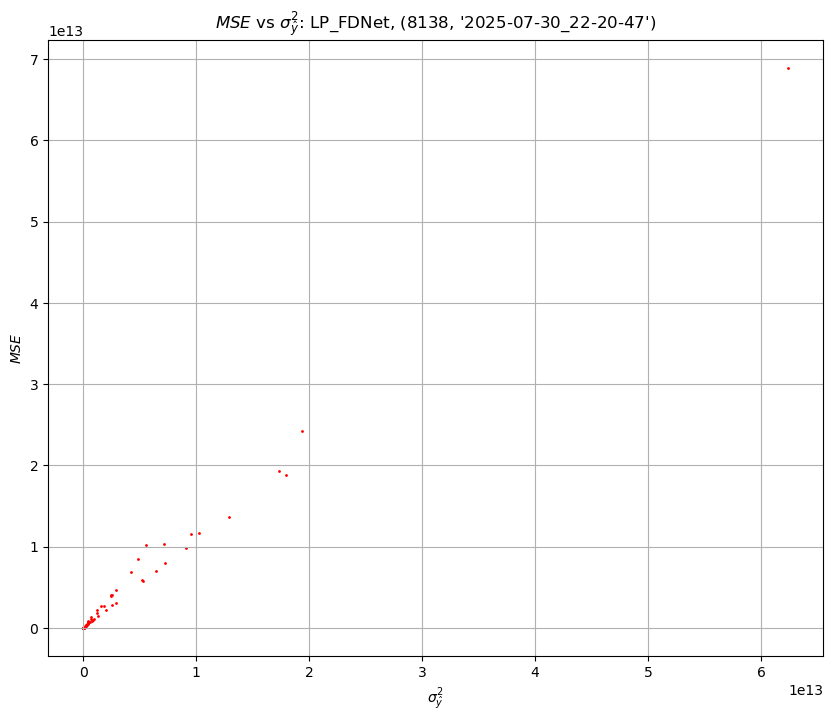

In [7]:

for seed_date_time in seed_data_time_list:

    stoch = metric_label in stoch_metrics
    models = sorted(stoch_models.intersection(model_types))

    for model in models:

        x = x_test[seed_date_time]
        y = y_test[seed_date_time]

        # mean = metrics["mean"][seed_date_time][model]
        var = metrics["var"][seed_date_time][model]

        # bias = metrics["bias"][seed_date_time][model]
        mse = metrics["mse"][seed_date_time][model]

        # res_prec = metrics["res_precision"][seed_date_time][model]
        # res_acc = metrics["res_accuracy"][seed_date_time][model]
    
        plt.figure(figsize=(10,8))
        plt.scatter(10*np.log10(var), 10*np.log10(mse), alpha=1.0, s=1, c="red")
        plt.xlabel("$\sigma_{\hat{y}}^{2}$ (dB)")
        plt.ylabel("$MSE$ (dB)")
        plt.title("$MSE$ vs $\sigma_{\hat{y}}^{2}$ (dB): " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10,8))
        plt.scatter(var, mse, alpha=1.0, s=1, c="red")
        plt.xlabel("$\sigma_{\hat{y}}^{2}$")
        plt.ylabel("$MSE$")
        plt.title("$MSE$ vs $\sigma_{\hat{y}}^{2}$: " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()

$MSE$ vs $Bias^{2}$
=

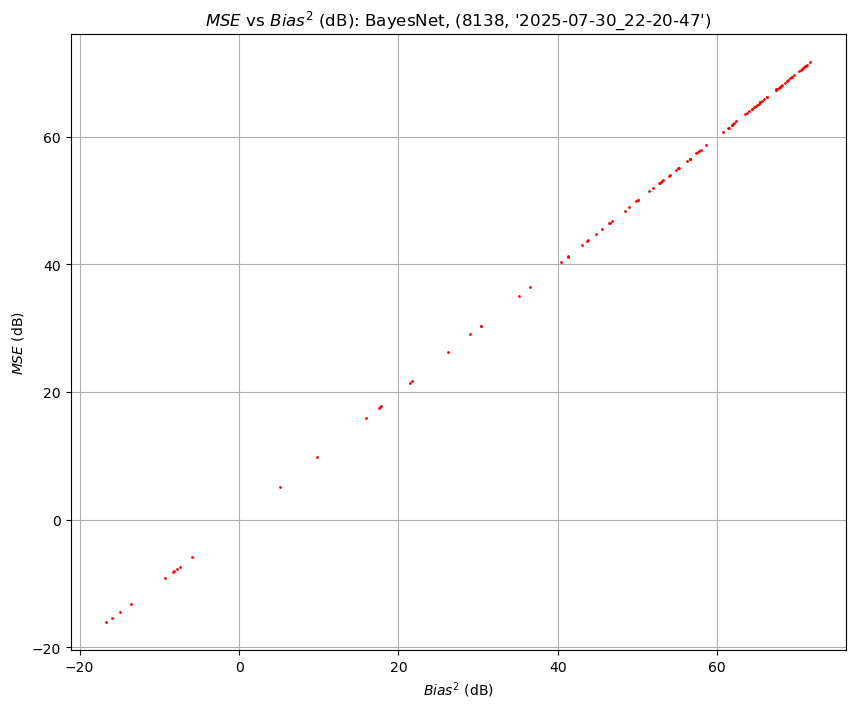

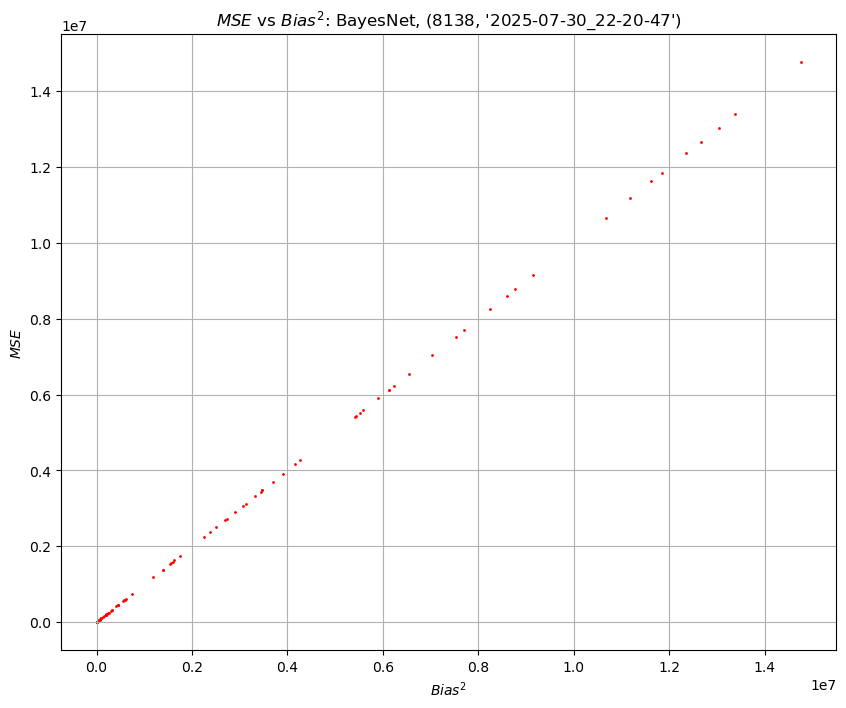

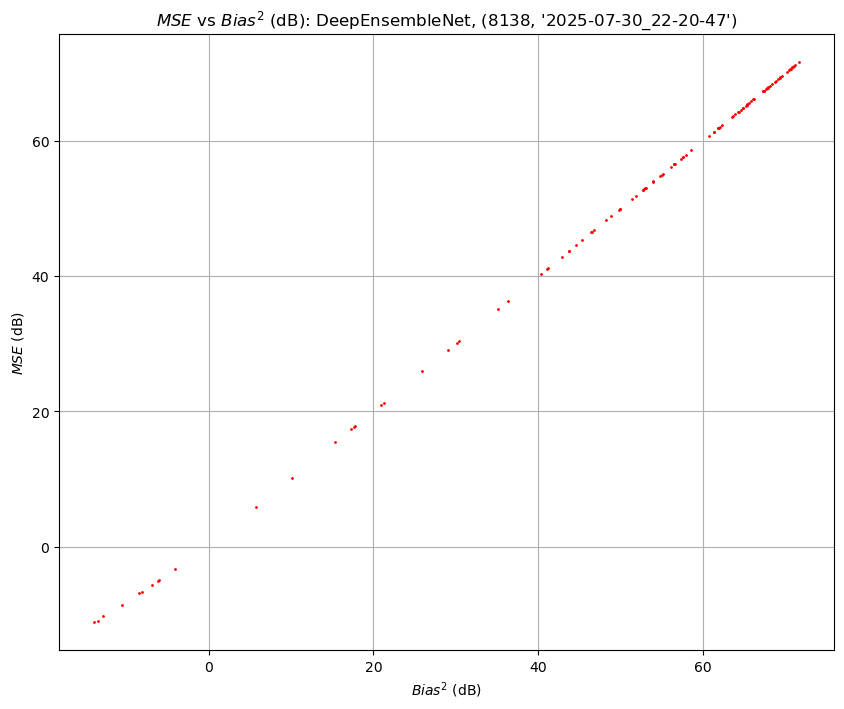

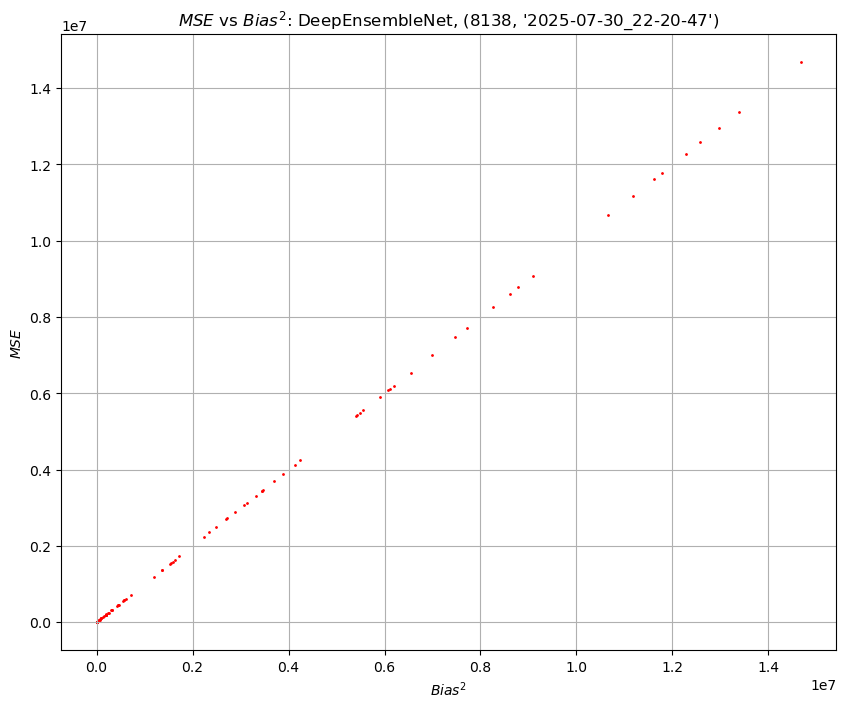

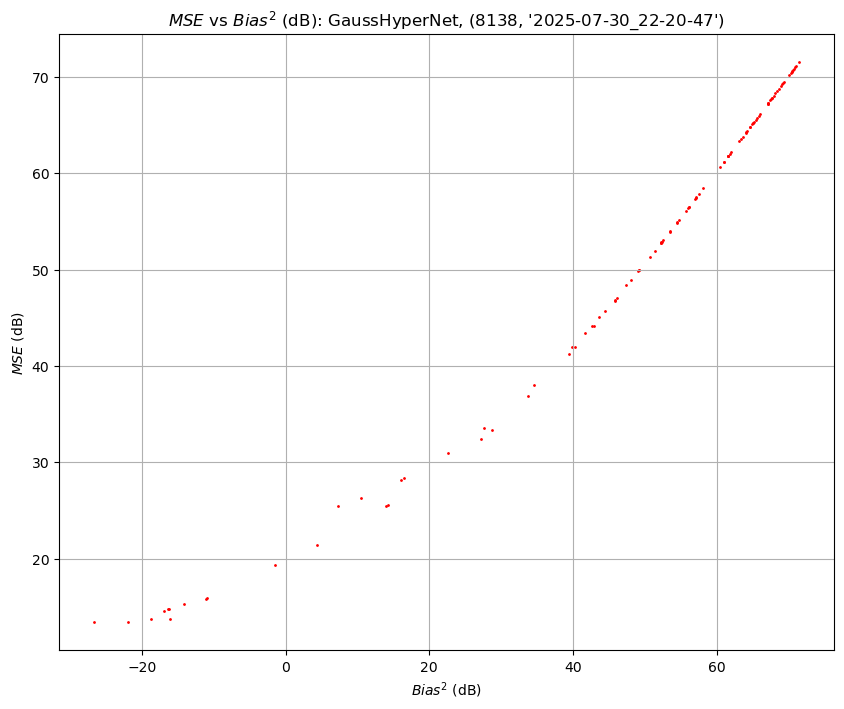

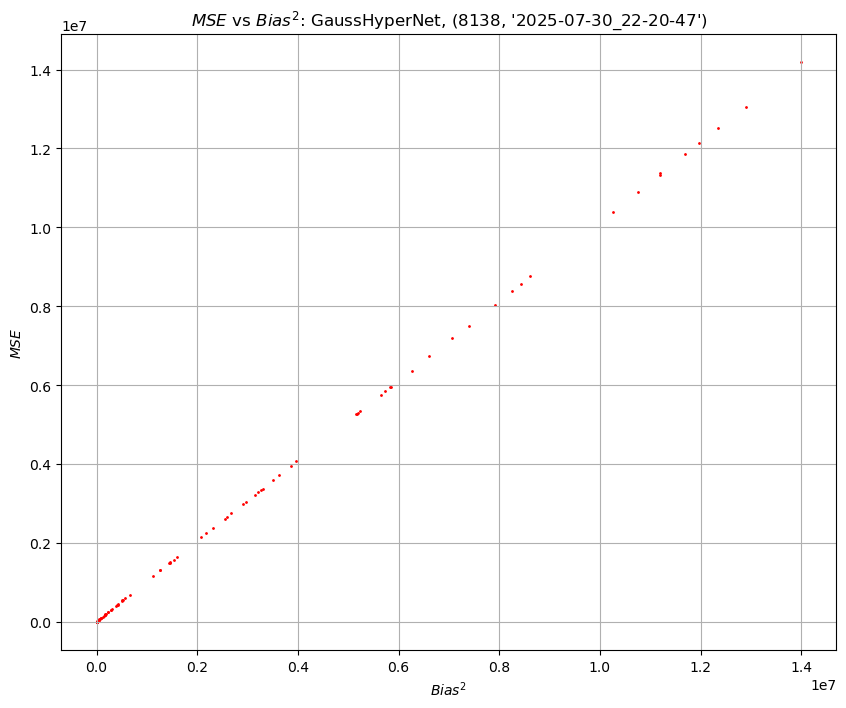

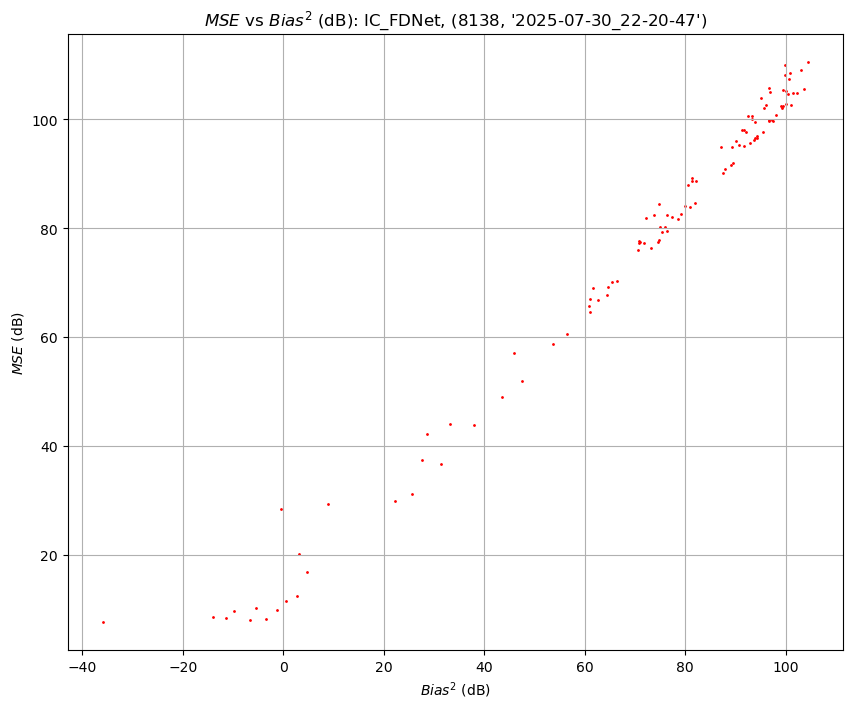

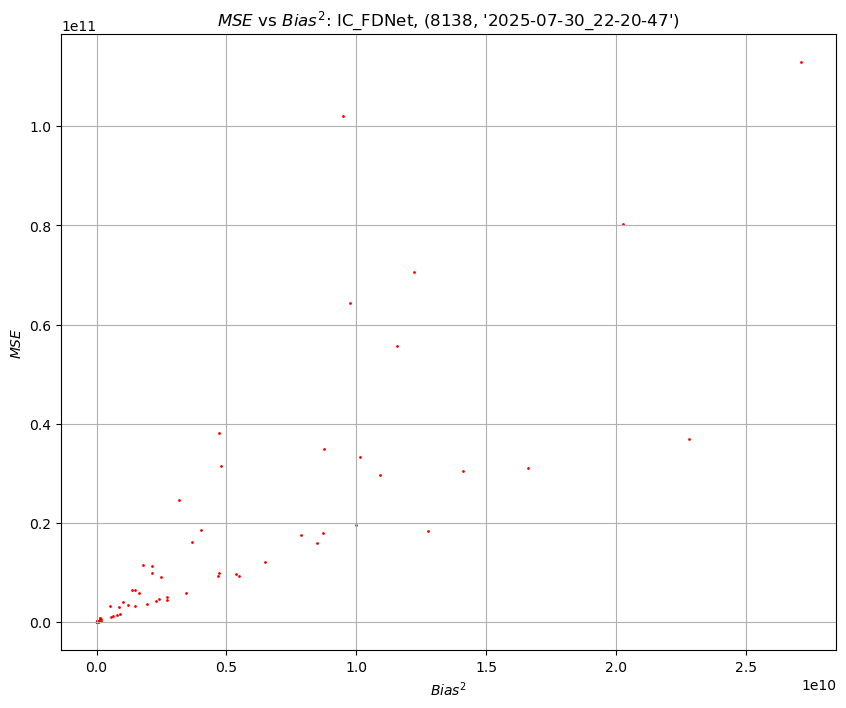

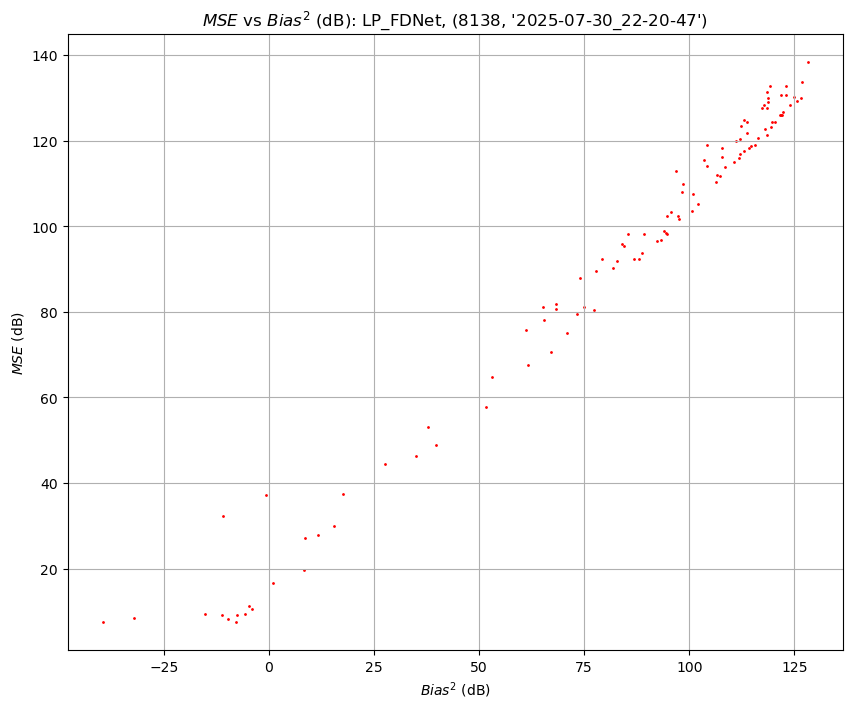

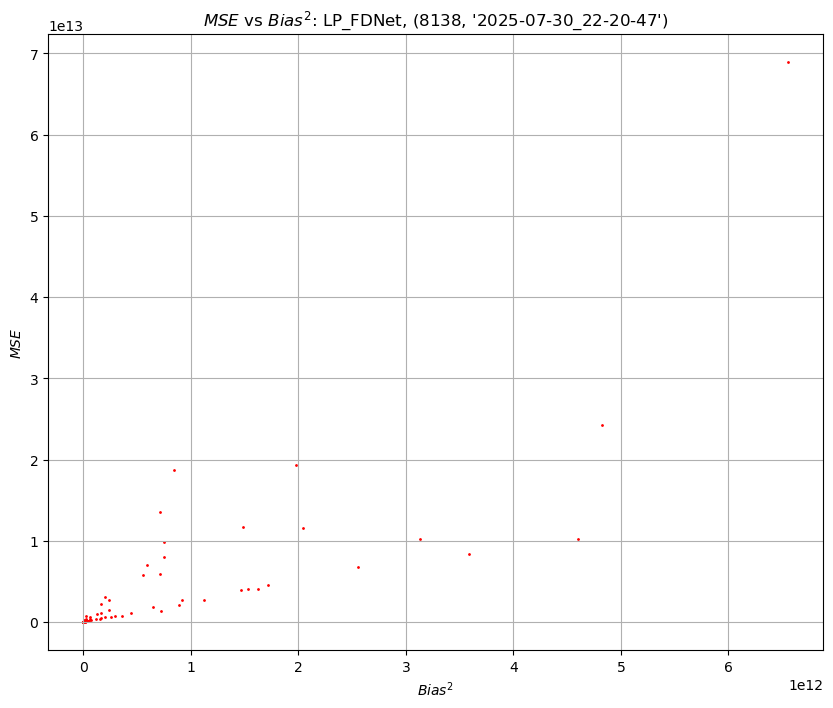

In [8]:

for seed_date_time in seed_data_time_list:

    stoch = metric_label in stoch_metrics
    models = sorted(stoch_models.intersection(model_types))

    for model in models:

        x = x_test[seed_date_time]
        y = y_test[seed_date_time]

        # mean = metrics["mean"][seed_date_time][model]
        # var = metrics["var"][seed_date_time][model]

        bias = metrics["bias"][seed_date_time][model]
        mse = metrics["mse"][seed_date_time][model]

        # res_prec = metrics["res_precision"][seed_date_time][model]
        # res_acc = metrics["res_accuracy"][seed_date_time][model]
    
        plt.figure(figsize=(10,8))
        plt.scatter(10*np.log10(bias**2), 10*np.log10(mse), alpha=1.0, s=1, c="red")
        plt.xlabel("$Bias^{2}$ (dB)")
        plt.ylabel("$MSE$ (dB)")
        plt.title("$MSE$ vs $Bias^{2}$ (dB): " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10,8))
        plt.scatter(bias**2, mse, alpha=1.0, s=1, c="red")
        plt.xlabel("$Bias^{2}$")
        plt.ylabel("$MSE$")
        plt.title("$MSE$ vs $Bias^{2}$: " + f"{model}, {seed_date_time}")
        plt.grid(True)
        plt.show()